# MIDDEN Salt Model - Open Exploration

## Model initialization

In [1]:
from __future__ import (division, print_function, absolute_import, unicode_literals)
from ema_workbench import (RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, 
                           ema_logging, perform_experiments, save_results, load_results)
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.em_framework import (salib_samplers, samplers, util,
                                        MultiprocessingEvaluator, SequentialEvaluator) 
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy.lib.recfunctions as rf
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import pandas as pd

C:\Users\Edzard\Anaconda\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\Edzard\Anaconda\lib\site-packages\xarray\core\formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
ema_logging.log_to_stderr(level=ema_logging.INFO)

model = ExcelModel("excelmodel", wd="./Models", model_file='MIDDEN Decarbonization options salt.xlsx')

#name of the sheet
model.sheet = "Experiment"

# Specification of the uncertainties
model.uncertainties = [IntegerParameter("Price_scenario", 1, 3),               # Integer value 1, 2, 3
                       RealParameter("Discount_rate", 0.0075, 0.05),           # May fluctuate between 2% and 5%
                       RealParameter("Production_uncertainty", 0.85, 1.15),    # May fluctuate between between 85% and 115% 
                       RealParameter("Efficiency_gain", 0.0025, 0.0075),       # Yearly efficiency gain approx 0.5% (DNGVL)
                       IntegerParameter("Investment_year", 2020, 2030)         # Integer value range 2020 – 2030
                      ]


# Specification of the policies
model.levers = [IntegerParameter('Decarbonization_pathway', 0, 3), # 0=None; 1=Electric boilers; 2=MVR technology; 3=Hybrid
                IntegerParameter('Energy_tax', 0, 2),              # 0=None; 1=10%; 2=20%
                IntegerParameter("Plant_number", 1, 4),                # 1=Hengelo; 2=Delfzijl; 3=Harlingen; 4=Veendam
                IntegerParameter('Coal_plants_shutdown', 0, 1)     # 0=Present policy, 1=Envisaged policy
               ]

# Specification of the outcomes
model.outcomes = [ScalarOutcome("Total_emissions", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Direct_emissions_change_norm", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_emissions_change_norm", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Emission_change_norm", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Energy_usage_change_norm", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("IRR", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("NPV", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("NPV_norm", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Yearly_production", kind=ScalarOutcome.MINIMIZE)
                 ]

 ### Running experiment with policies


In [3]:
#Running with policies
n_scenarios = 150
n_policies = 24*4
results_bckp = './Data/results {} scenarios {} policies.tar.gz'.format(n_scenarios, n_policies)

counter = util.Counter()
policies = samplers.sample_levers(model, n_policies)

try:
    # Load results if experiment has already been conducted
    results = load_results(results_bckp)

except IOError:
    # Running in parallel   
    with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, policies)
    
    #Running in series
    #results = perform_experiments(model, n_scenarios)
    
    save_results(results, results_bckp)

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\Edzard\Documents\MIDDEN modeling\Data\results 150 scenarios 96 policies.tar.gz


In [4]:
# Creating experiment DataFrame
experiment_data=pd.DataFrame(experiments)
outcome_data = pd.DataFrame(outcomes)

In [5]:
results_df=pd.concat([experiment_data, outcome_data], axis=1)
results_df.head(3)

,Discount_rate,Efficiency_gain,Investment_year,Price_scenario,Production_uncertainty,Coal_plants_shutdown,Decarbonization_pathway,Energy_tax,Plant_number,scenario_id,...,model,Total_emissions,Direct_emissions_change_norm,Indirect_emissions_change_norm,Emission_change_norm,Energy_usage_change_norm,IRR,NPV,NPV_norm,Yearly_production
0,0.019086,0.004032,2024,2,0.994737,1,2,2,2,0,...,excelmodel,114.686471,-0.114091,0.032675,-0.086047,-507.428154,0.586718,2.191319e+08,72536.211577,3021.0
1,0.044186,0.006368,2030,1,0.864531,1,2,2,2,1,...,excelmodel,136.628725,-0.099605,0.026814,-0.062552,-508.426217,0.565825,1.947910e+08,64478.989394,3021.0
2,0.034596,0.003518,2025,3,0.889596,1,2,2,2,2,...,excelmodel,106.473995,-0.102027,0.029238,-0.075658,-453.060469,0.324979,1.444246e+08,47806.878503,3021.0


## Basic Visual Analysis

In [6]:
import seaborn as sns

[MainProcess/INFO] no time dimension found in results


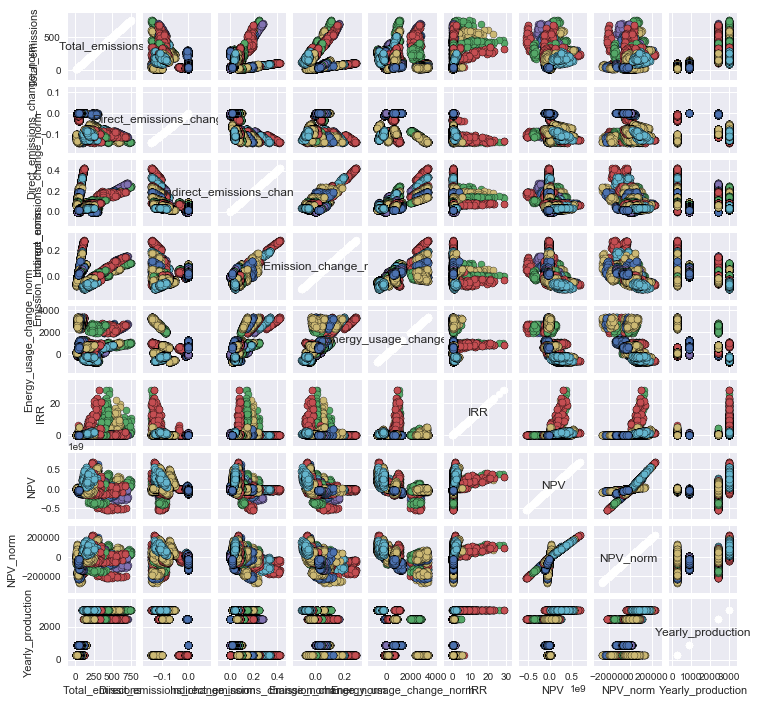

In [7]:
import ema_workbench.analysis.pairs_plotting as pairs

fig, axes = pairs.pairs_scatter(results, group_by='policy', legend=False)

fig.set_figheight(12)
fig.set_figwidth(12)

for ax in axes.values():
    ax.locator_params(nbins=4)

plt.show()

In [8]:
import copy
experiments, outcomes = results
policy_column = experiments['policy']

data = copy.copy(outcomes)
data['policy'] = policy_column
data.keys()

data = pd.DataFrame(data)

data['Pos_IRR']=data.IRR>0 
data['Neg_Emission_change_norm']=data.Emission_change_norm<0
data['Filter']= data['Pos_IRR']&data['Neg_Emission_change_norm']

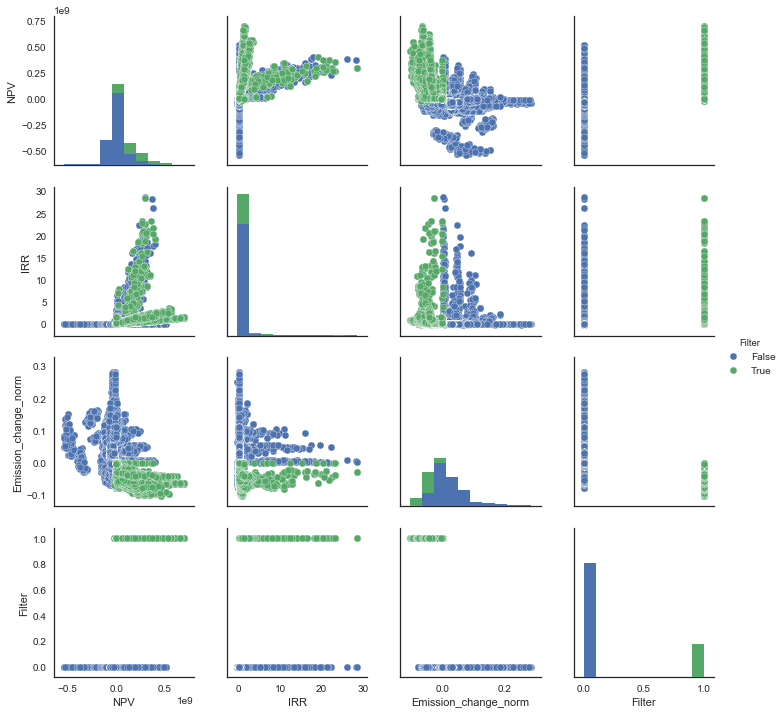

In [9]:
plotdata=data[['NPV','IRR','Emission_change_norm','Filter']]

sns.set(style="ticks", color_codes=True)    
with sns.axes_style('white'):
    sns.pairplot(plotdata, hue='Filter')
plt.show()

## Feature scoring

In [10]:
import numpy.lib.recfunctions as rf

experiments, outcomes = results

In [11]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes['Emission_change_norm']

fs, _ = feature_scoring.get_rf_feature_scores(x,y, mode=feature_scoring.REGRESSION)
fs

C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Edzard\Anaconda\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


,0,1
0,policy,0.541682
1,Plant_number,0.273153
2,Decarbonization_pathway,0.118974
3,Energy_tax,0.031607
4,Investment_year,0.024650
5,Production_uncertainty,0.007777
6,Coal_plants_shutdown,0.001208
7,Efficiency_gain,0.000793
8,Discount_rate,0.000104
9,Price_scenario,0.000051


### Feature scoring uncertainties to performance metrics

In [12]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Coal_plants_shutdown', 'Decarbonization_pathway','Energy_tax','Plant_number','policy','model'], 
                   asrecarray=True)

In [13]:
# Defining the y-space for the feature scoring
y_df = pd.DataFrame(outcomes)
y_df=y_df[['Emission_change_norm','Energy_usage_change_norm','IRR','NPV_norm']]

y_dict = y_df.to_dict('list')
for key in y_dict.keys():
    y_dict[key] = np.array(y_dict[key])

In [14]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

y = y_dict

fs_all = get_feature_scores_all(x, y)
fs_all

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

,Emission_change_norm,Energy_usage_change_norm,IRR,NPV_norm
Discount_rate,0.154746,0.157817,0.070206,0.030714
Efficiency_gain,0.180671,0.214514,0.075834,0.029615
Investment_year,0.408902,0.204875,0.297180,0.040817
Price_scenario,0.089737,0.095958,0.145401,0.552086
Production_uncertainty,0.165944,0.326837,0.411379,0.346767


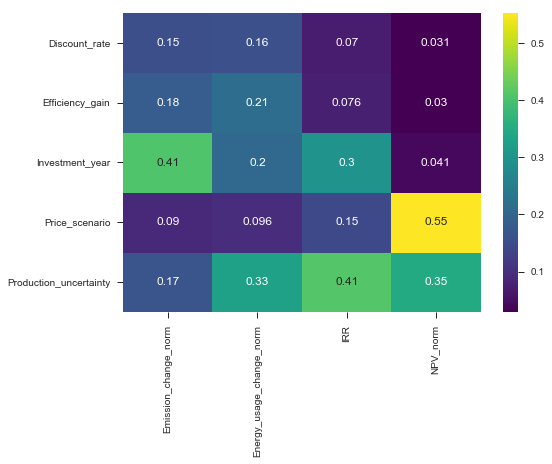

In [15]:
sns.heatmap(fs_all, annot=True, cmap='viridis')
plt.show()

### Feature scoring for policy levers

In [16]:
experiments, outcomes = results

In [17]:
# Defining the x space for feature scoring
x = experiments
x = rf.drop_fields(x, ['Discount_rate','Efficiency_gain','Investment_year','Price_scenario','model'], 
                   asrecarray=True)

In [18]:
fs_all = get_feature_scores_all(x, y)
fs_all

C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

,Emission_change_norm,Energy_usage_change_norm,IRR,NPV_norm
Coal_plants_shutdown,0.086219,0.003858,0.012025,0.014167
Decarbonization_pathway,0.266305,0.601092,0.204538,0.144999
Energy_tax,0.084369,0.009247,0.062882,0.040302
Plant_number,0.279805,0.341541,0.231226,0.417069
Production_uncertainty,0.042137,0.011859,0.438273,0.338179
policy,0.241164,0.032402,0.051057,0.045285


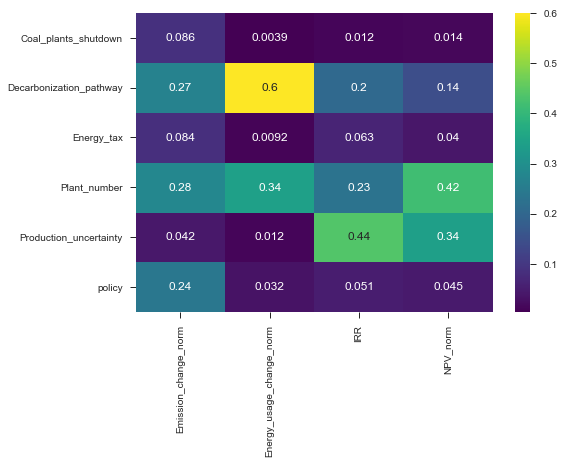

In [19]:
sns.heatmap(fs_all, annot=True, cmap='viridis')
plt.show()

## Dimensional Stacking

### Comparison between filters on NPV_norm, Neg_emission_change_norm and both

In [20]:
outcome_data['Neg_Emission_change_norm']=outcome_data['Emission_change_norm']<0 
outcome_data['Pos_IRR']=outcome_data['IRR']>0
outcome_data['Pos_NPV_norm']=outcome_data['NPV_norm']>0
outcome_data['Filter0']=outcome_data['Pos_NPV_norm']
outcome_data['Filter1']=outcome_data['Neg_Emission_change_norm']
outcome_data['Filter2']=outcome_data['Pos_NPV_norm']&outcome_data['Neg_Emission_change_norm']

In [21]:
# Selecting relevant dataframes for scenario analysis
x_df=experiment_data[['Efficiency_gain', 'Investment_year', 'Production_uncertainty','Price_scenario']]
y_df=outcome_data['Filter1']

# Converting dataframes to arrays
x = x_df.to_records(index=False)
y = y_df.values

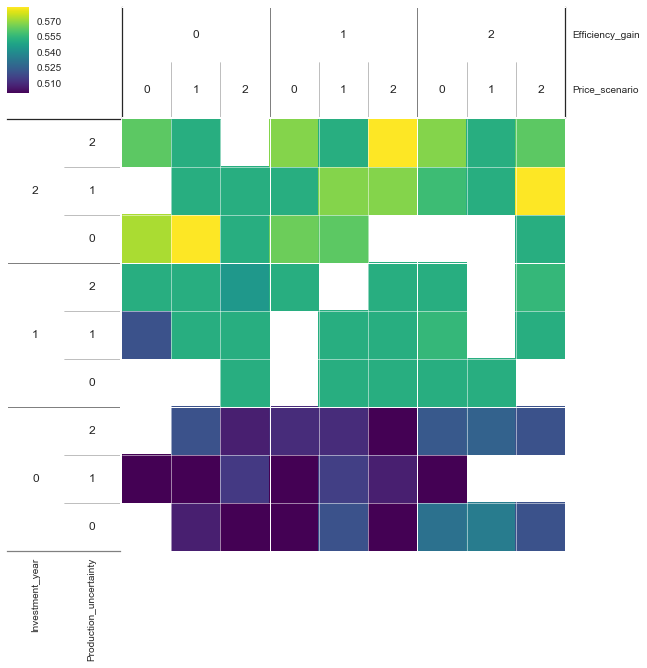

In [22]:
from ema_workbench.analysis.dimensional_stacking import create_pivot_plot

scores = create_pivot_plot(x,y, 2, nbins=3)
plt.show()

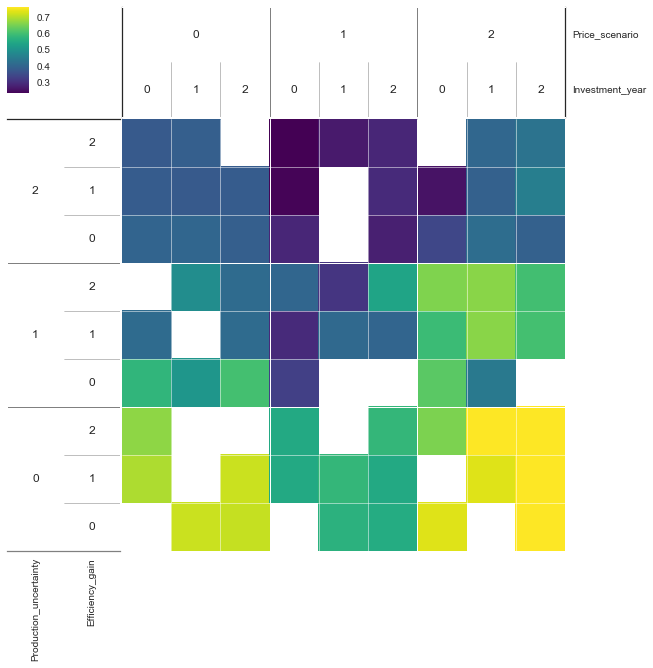

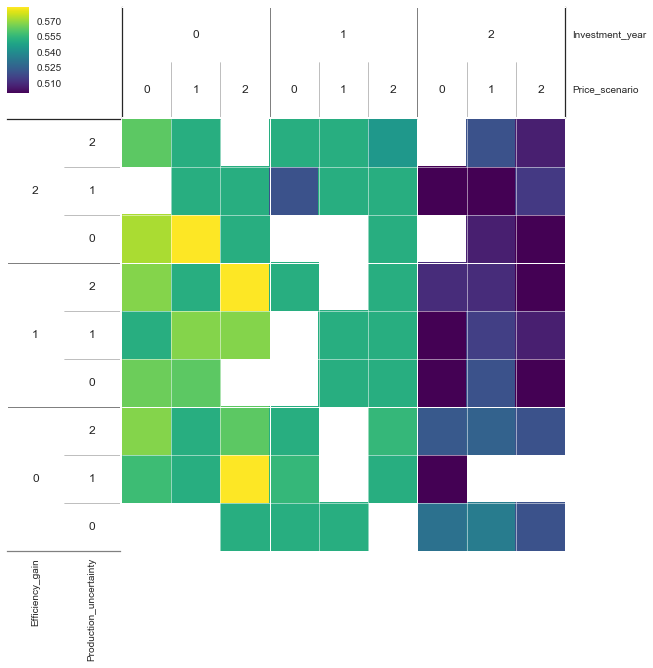

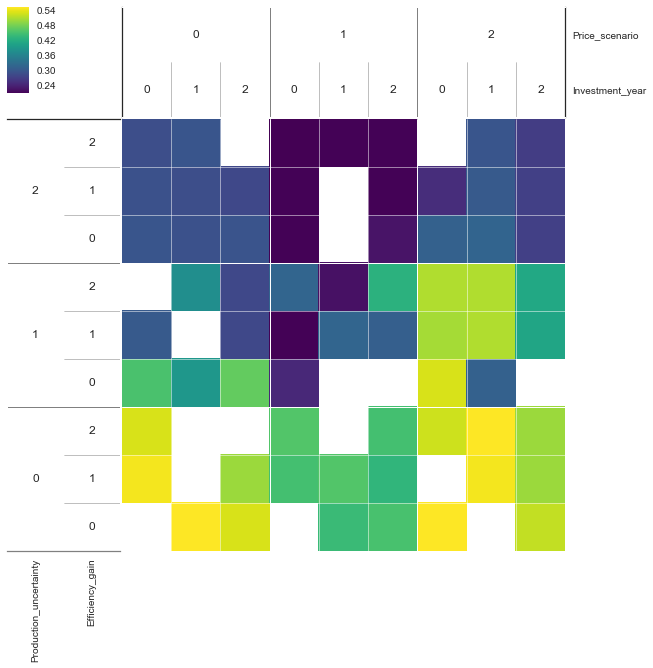

In [23]:
for filter_number in range(0,3):
    # Selecting relevant dataframes for scenario analysis
    x_df=experiment_data[['Efficiency_gain', 'Investment_year', 'Production_uncertainty','Price_scenario']]
    y_df=outcome_data['Filter'+str(filter_number)]

    # Converting dataframes to arrays
    x = x_df.to_records(index=False)
    y = y_df.values
    scores = create_pivot_plot(x,y, 2, nbins=3)
plt.show()

## Scenario discovery (PRIM)

In [24]:
outcome_data_test=outcome_data
outcome_data_test['Neg_Emission_change_norm']=outcome_data_test['Emission_change_norm']<0 
outcome_data_test['Pos_IRR']=outcome_data_test['IRR']>0
outcome_data_test['Pos_NPV_norm']=outcome_data_test['NPV_norm']>0
outcome_data_test['Filter']=outcome_data_test['Pos_NPV_norm']&outcome_data_test['Neg_Emission_change_norm']

In [25]:
# Selecting relevant dataframes for scenario analysis
x_df=experiment_data[['Discount_rate','Efficiency_gain','Production_uncertainty','Investment_year','Price_scenario']]
y_df=outcome_data_test['Filter']

# Converting dataframes to arrays
x = x_df.to_records(index=False)
y = y_df.values

# Running the Patient rule induction (PRIM) algorithm 
prim_alg = prim.Prim(x,y, threshold=0.1)
box_1 = prim_alg.find_box()

[MainProcess/INFO] 14400 points remaining, containing 5501 cases of interest
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
[MainProcess/INFO] mean: 0.53125, mass: 0.11333333333333333, coverage: 0.157607707689511, density: 0.53125 restricted_dimensions: 4


In [26]:
box_1.show_ppt()
#plt.show()
box_1.show_tradeoff()
mpld3.display()

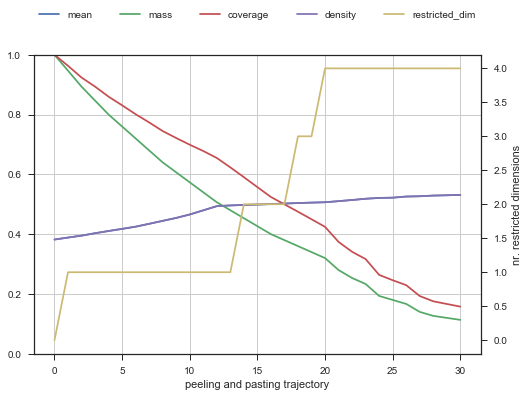

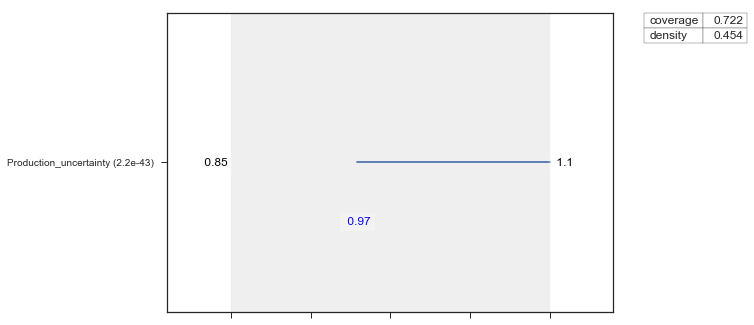

In [27]:
box_1.inspect(9, style='graph')
plt.show()

## PCA PRIM

In [28]:
x

rec.array([(0.019086291064487296, 0.00403154817823025, 0.994737093034528, 2024, 2),
 (0.04418628740305509, 0.006368037365438103, 0.8645312020721757, 2030, 1),
 (0.03459569248803883, 0.003517808383659232, 0.8895961339351675, 2025, 3),
 ...,
 (0.0364780915848516, 0.007418129968483856, 0.9581409098870124, 2025, 3),
 (0.02459572679873383, 0.00544736556576464, 0.8609071098160547, 2026, 1),
 (0.048416707030556665, 0.003181730211345481, 1.1297482807000732, 2030, 3)], 
          dtype=[('Discount_rate', '<f8'), ('Efficiency_gain', '<f8'), ('Production_uncertainty', '<f8'), ('Investment_year', '<i4'), ('Price_scenario', '<i4')])

In [29]:
subset={'Uncertainties':['Efficiency_gain', 'Investment_year', 'Production_uncertainty', 'Price_scenario']}

In [30]:
x = prim.Prim.perform_pca(subsets=x, exclude=['Efficiency_gain'])

TypeError: perform_pca() missing 1 required positional argument: 'self'

In [31]:
x = prim.Prim.perform_pca(x, subsets=subset, exclude=['Efficiency_gain'])

AttributeError: recarray has no attribute x

In [32]:
# Running the Patient rule induction (PRIM) algorithm 
prim_alg = prim.Prim(x,y, threshold=0.1)
box_1 = prim_alg.find_box()

[MainProcess/INFO] 14400 points remaining, containing 5501 cases of interest
C:\Users\Edzard\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
[MainProcess/INFO] mean: 0.53125, mass: 0.11333333333333333, coverage: 0.157607707689511, density: 0.53125 restricted_dimensions: 4
